In [1]:
import sys
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

### Intensity based Object Tracking

In [2]:
# Setup for object tracking

if not os.path.isdir(os.path.join(os.getcwd(), 'frames')):
    os.mkdir("frames")
else:
    print('frames already exists')

if not os.path.isdir(os.path.join(os.getcwd(), 'composite')):
    os.mkdir("composite")
else:
    print('composite already exists')
    
framenumber = 0
framectr = 0
omovie = cv2.VideoCapture('ping_pang.mov')
frame_height = omovie.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_width = omovie.get(cv2.CAP_PROP_FRAME_WIDTH)

# Extract the frames from original video
while(1):
    ret, frame = omovie.read()
    if not ret:
        break
    print('Extracting: %d' % framenumber)
    clear_output(wait=True)
    cv2.imwrite('frames/%d.tif' % framenumber, frame)
    framenumber += 1
omovie.release()

Extracting: 119


In [3]:
'''
    Find the object coordinate by averaging the foreground coordinates
    - Function Input: 
            -         frame:   numpy array, the frame to be processed
            -     threshold:           int, the threshold to segment the object

    - Function Output:
            - [object_x, object_y]: the coordinate of the object in the frame
'''
def findObj(frame, threshold):
    x_coors = []
    y_coors = []
    
    print(frame.shape)
    
    for row in range(frame.shape[0]):
        for col in range(frame.shape[1]):
            if frame[row,col,0] >= threshold and frame[row,col,1] >= threshold and frame[row,col,2] >= threshold:
                x_coors.append(row)
                y_coors.append(col)
    
    if len(x_coors) < 100:
        return [-1,-1]
    obj_coor = [sum(x_coors)/len(x_coors), sum(y_coors)/len(y_coors)]
    print('length', len(x_coors))
    
    return obj_coor


# Draw a circle on the image
def drawbox(frame, centerx, centery, radius, color):
    for y in range(centerx - radius, centerx + radius):
        for x in range(centery - radius, centery + radius):
            cx = 0 if x < 0 else frame.shape[0]-1 if x > frame.shape[0] - 1 else x
            cy = 0 if y < 0 else frame.shape[1]-1 if y > frame.shape[1] - 1 else y
            for i in range(3):
                frame[cx][cy][i] = color[i]
    return frame

In [4]:
framectr = framenumber - 1
process_frame = 0

foreground = 250 # Foreground Threshold for Segmentation
# Store the coordinates found by intensity thresholding
coordListX = list()
coordListY = list()

while process_frame <= framectr:
    oframe = cv2.imread('frames/%d.tif' % process_frame)
    print('Processing frame: %d, overall progress: %.2f %%' % (process_frame, process_frame/framectr*100))
    clear_output(wait=True)
    
    # Change frame to grey scale
    gframe = oframe.copy() # Grey scaled frame

    # Load the saved frames sequentially
    height = None
    width = None
    for y in range(gframe.shape[1]):
        for x in range(gframe.shape[0]):
            # Convert to gray scale
            g = 0.212671 * gframe[x][y][2] + 0.715160 * gframe[x][y][1] + 0.072169 * gframe[x][y][0]

            # Convert to binary
            for i in range(3):
                if g > foreground:
                    gframe[x][y][i] = 255
                else:
                    gframe[x][y][i] = 0

    # Get the initial state (object coordinates) from binary segmentation
    coord = findObj(gframe, 128) # coord is the centre of mass
                                 # coord[0] : y column
                                 # coord[1] : x row
            
    # Draw a red dot in the centre of the segmented object
    gframe = drawbox(gframe, int(coord[1]), int(coord[0]), 5, (0, 0, 255))
    oframe = drawbox(oframe, int(coord[1]), int(coord[0]), 5, (0, 0, 255))
    
    for i in range(len(coordListX)-1):
        cv2.line(oframe, (coordListX[i], coordListY[i]), (coordListX[i+1], coordListY[i+1]), (0, 0, 255), 2)
    
    if coord == [-1,-1]:
        cv2.line(oframe, (0,0), (int(coord[1]), int(coord[0])), (0, 0, 255), 2)
    
    combined_img = np.hstack((oframe, gframe))
    
    if coord == [-1,-1]:
        cv2.putText(combined_img, text='Object missing', 
                    org=(2200, 1000),fontFace=cv2.FONT_HERSHEY_DUPLEX, 
                    fontScale=5, thickness = 5, color=(0, 255, 0))
    else:
        cv2.putText(combined_img, text='Object found', 
                    org=(2200, 1000),fontFace=cv2.FONT_HERSHEY_DUPLEX, 
                    fontScale=5, thickness = 5, color=(0, 255, 0))
    
        coordListX.append(int(coord[1]))
        coordListY.append(int(coord[0]))
        
    cv2.imwrite('composite/composite%d.tif' % process_frame, combined_img)
    if cv2.waitKey(30) & 0xff == ord('q'):
        break
    process_frame += 1

(1080, 1920, 3)


In [5]:
count = 0
out = cv2.VideoWriter('./tracking_results.mov', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 10, (int(frame_width*2), int(frame_height)))
while(1):
    img = cv2.imread('composite/composite%d.tif' % count)
    if img is None:
        print('No more frames to be loaded')
        break
    clear_output(wait=True)
    out.write(img)
    count += 1
    print('Saving video: %d%%' % int(100*count/framenumber))
    
out.release()
cv2.destroyAllWindows()

Saving video: 100%
No more frames to be loaded


[ WARN:0@5184.250] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('composite/composite120.tif'): can't open/read file: check file path/integrity


### Generate Results

In [6]:
def generate_results(output_video):
    cap = cv2.VideoCapture(output_video)
    random_frames = []
    if not cap.isOpened():
        print('%s not opened' % output_video.split('/')[-1])
        sys.exit(1)

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    x = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    y = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    while x > 10:
        x /= (x / 10)
        y /= (y / 10)
    
    random_frames.append(random.randint(53, 63))
    random_frames.append(random.randint(66, 76))
    random_frames.append(random.randint(80, 94))
        
    fig, axs = plt.subplots(3, 1, figsize=(x,y))
        
    count = 0
    output_count = 0
    while(1):
        ret, frame = cap.read()
        if not ret:
            break
        if count in random_frames:
            frame_m = frame.copy()
            frame_R = frame[:,:,2]
            frame_B = frame[:,:,0]
            frame_m[:,:,2] = frame_B
            frame_m[:,:,0] = frame_R
            frame = np.uint8(frame_m)

            axs[output_count].imshow(frame_m)
            axs[output_count].text(0.5,-0.1, 'Composite frame: ' + str(count), size=12, ha="center", transform=axs[output_count].transAxes)
            axs[output_count].axis('off')
            output_count+=1
            
            if output_count >= 3:
                break
        count+=1

    cap.release()
    cv2.destroyAllWindows()
    plt.tight_layout()
    plt.show()

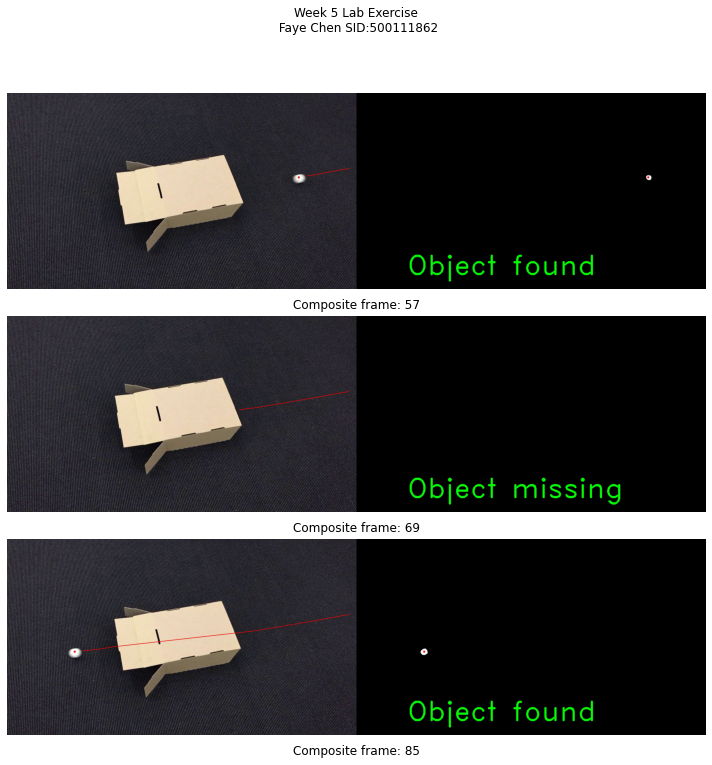

In [7]:
# Change the 'path_to_output' to the path where your composited video is located
path_to_output = './tracking_results.mov'
generate_results(path_to_output)